# **CS722 Machine Learning Semester Project**
## **Image Style Transfer Using Convolutional Neural Networks**

### Members: Apurva Modi, Maruf Sakib, Lalita Sharkey

In [0]:
from google.colab import drive
#drive.mount('/content/drive')

## Importing Packages

In [0]:
# Packages
import numpy as np
from PIL import Image
import time
import functools
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False
np.random.seed(7)

%matplotlib inline

# TensorFlow Packages
try:
  %tensorflow_version 2.x
except Exceptions:
  pass
import tensorflow as tf
from tensorflow.python.keras.preprocessing import image as preImage
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


## Loading Image Paths

In [0]:
import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /tmp/nst/ https://cdn.shopify.com/s/files/1/0627/1477/products/Starry_Night_03d43ad7-d879-40ef-8525-5f3c38918acc_large.jpg?v=1542461422
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/Tuebingen_Neckarfront.jpg/800px-Tuebingen_Neckarfront.jpg
!wget --quiet -P /tmp/nst/ https://github.com/LalitaSharkey/CS620_data_science/blob/master/the_shipwreck_of_the_minotaur.jpg?raw=true
!wget --quiet -P /tmp/nst/ https://github.com/LalitaSharkey/CS620_data_science/blob/master/The_Scream.jpg?raw=true
!wget --quiet -P /tmp/nst/ https://github.com/LalitaSharkey/CS620_data_science/blob/master/Pablo_Picasso.jpg?raw=true
!wget --quiet -P /tmp/nst/ https://github.com/LalitaSharkey/CS620_data_science/blob/master/36.jpg?raw=true
!wget --quiet -P /tmp/nst/ https://github.com/LalitaSharkey/CS620_data_science/blob/master/Norfolk.jpg?raw=true
!wget --quiet -P /tmp/nst/ https://livability.com/sites/default/files/NorfolkVA-CitySkylineWater.jpg


In [0]:
style_path  = '/tmp/nst/NorfolkVA-CitySkylineWater.jpg'
content_path = '/tmp/nst/Norfolk.jpg?raw=true'

## Displaying the Loaded Images
We can load in any images you want! Below, we've provided a helper function for loading in any type and size of image, using the above mentioned content and the style paths

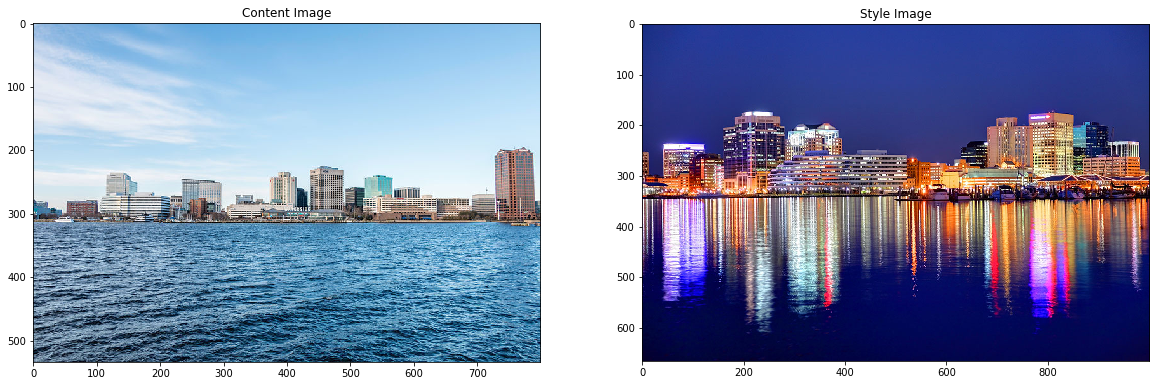

In [0]:
# Load the content and style images
content = plt.imread(content_path)
style = plt.imread(style_path)

# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Content and style images side-by-side
ax1.imshow(content)
ax1.set_title('Content Image')
ax2.imshow(style)
ax2.set_title('Style Image')
plt.show()

NOTE: It will be easier to have smaller images and to squish the content and style images so that they are of the same siz

In [0]:
def load_image(image):
  #  We need to broadcast the image array such that it has a batch dimension 0)
  image = plt.imread(image)
  img = tf.image.convert_image_dtype(image, tf.float32)
  img = tf.image.resize(img, [512, 512])
  # Shape -> (batch_size, h, w, d)
  img = img[tf.newaxis, :]
  return img

In [0]:
# Use load_image of content and style images
contentC = load_image(content_path)
styleS = load_image(style_path)

# Verify the shapes
contentC.shape, styleS.shape

(TensorShape([1, 512, 512, 3]), TensorShape([1, 512, 512, 3]))

## Data preparation
helper function for un-normalizing an image 
and converting it from a Tensor image to a NumPy image for display

In [0]:
# Preprocess according to VGG training Process
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = preImage.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

def load_and_process_img(image):
  processed_img = load_img(image)
  processed_img = tf.keras.applications.vgg19.preprocess_input(processed_img)
  return processed_img

# Inverse Preprocessing
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  # mainting the values from 0-255 rangw
  x = np.clip(x, 0, 255).astype('uint8')
  return x

## VGG19 Model 
To get the content and style representations of an image, we have to pass an image forward throug the VGG19 network until we get to the desired layer(s) and then get the output from that layer.



In [0]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

80142336/80134624 [==============================] - 6s 0us/step


In [0]:
# Print the layer names for convenience
for layer in vgg.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


## Defining Content and the Style features
Below, complete the mapping of layer names to the names found in the paper for the content representation and the style representation 

In [0]:
""" Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
"""
# get content and style features only once before training

# Content layer
content_layers = ['block4_conv2']

# Style layer
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']


num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Building the MODEL
Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model.

In [0]:
def build_model():
  """ 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

## Compute Loss
The content loss will be the mean squared difference between the target and content features at layer conv4_2. This can be calculated as follows:

In [0]:
def content_loss(content, targetImage):
  return tf.reduce_mean(tf.square(content - targetImage))

## Style Loss
The style loss is calculated in a similar way, only you have to iterate through a number of layers, specified by name in our dictionary style_weights

We'll calculate the gram matrix for the target image, gram_target and style image style at each of these layers and compare those gram matrices, calculating the gram_style. Later, we'll see that this value is normalized by the size of the layer.

In [0]:
def gram_matrix(tensor):
  """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
  """
  # We make the image channels first 
  channels = int(tensor.shape[-1])
  a = tf.reshape(tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def style_loss(style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = style.get_shape().as_list()
  gram_style = gram_matrix(style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))

##Get style and content Representation from the Model
Helper function to compute our content and style feature representations.

  This function will simply load and preprocess both the content and style 
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers. 

In [0]:
def getFeatureRepresentations(model, content, style):
  """
  Arguments:
    model: The model that we are using,i.e, VGG19.
    content: The path to the content image.
    style: The path to the style image
    
  Returns:
    returns the style features and the content features. 
  """
  # Load our images in 
  content_image = load_and_process_img(content)
  style_image = load_and_process_img(style)
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

## Compute Total Loss
This function will compute the loss total loss.

In [0]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  """
  Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.
      
  Returns:
    returns the total loss, style loss, content loss, and total variational loss
  """
  style_weight, content_weight = loss_weights
  
  # This will give us the content and style representations at our desired layers. 
  model_outputs = model(init_image)
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  style_score = 0
  content_score = 0
  # Normalize STYLE LOSS
  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * style_loss(comb_style[0], target_style)
  # Normalize CONTENT LOSS
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* content_loss(comb_content[0], target_content)
  # TOTAL LOSS IS THE LINEAR COMBINATION OF STYLE AND CONTENT LOSS
  style_score *= style_weight
  content_score *= content_weight
  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

## Compute Gradient
With GradientTape, you can take advantage of automatic differentiation, which can calculate the gradients of a function based on its composition. You will also use the tf.function decorator to speed up the operations.

In [0]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    # Extract the features
    # Calculate the loss
    all_loss = compute_loss(**cfg)
  # Determine the gradients of the loss function w.r.t the image pixels
  total_loss = all_loss[0]
  # Update the pixels
  # Clip the pixel values that fall outside the range of [0,1]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

## Style transfer Algorithm
This is the main optimization algorithm for the Style-Transfer algorithm. It is basically just gradient descent on the loss-functions defined above.

This algorithm also uses normalization of the loss-functions. This appears to be a novel idea not previously published. In each iteration of the optimization, the loss-values are adjusted so each of them equals one. This allows the user to set the loss-weights independently of the chosen style- and content-layers. It also adapts the weighting during optimization to ensure the desired ratio between style, content and denoising is preserved.

In [0]:
%%time
import IPython.display

def run_style_transfer(content_path, style_path, num_iterations=1000, content_weight=1, style_weight=10e-5): 
    """
    Use gradient descent to find an image that minimizes the
    loss-functions of the content-layers and style-layers. This
    should result in a mixed-image that resembles the contours
    of the content-image, and resembles the colours and textures
    of the style-image.

    Parameters:
    content_path: Numpy 3-dim float-array with the content-image.
    style_path: Numpy 3-dim float-array with the style-image.
    content_weight: Weight for the content-loss-function.
    style_weight: Weight for the style-loss-function.
    num_iterations: Number of optimization iterations to perform.
    """
    # We don't need to (or want to) train any layers of our model, so we set their
    # trainable to false. 
    model = build_model()
    for layer in model.layers:
      layer.trainable = False
    # Get the style and content feature representations (from our specified intermediate layers) 
    style_features, content_features = getFeatureRepresentations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    # Set initial image
    init_image = load_and_process_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
    # Create our optimizer
    #opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
    opt= tf.optimizers.Adam(learning_rate= 5)
    # For displaying intermediate images 
    iter_count = 1
    # Store our best result
    best_loss, best_img = float('inf'), None
    # Create a nice config 
    loss_weights = (style_weight, content_weight)
    cfg = {'model': model,'loss_weights':loss_weights,
        'init_image': init_image, 'gram_style_features': gram_style_features,
        'content_features': content_features }  
    # For displaying
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
    imgs = []
    for i in range(num_iterations):
      grads, all_loss = compute_grads(cfg)
      loss, style_score, content_score = all_loss
      opt.apply_gradients([(grads, init_image)])
      clipped = tf.clip_by_value(init_image, min_vals, max_vals)
      init_image.assign(clipped)
      end_time = time.time() 
      if loss < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = loss
        best_img = deprocess_img(init_image.numpy())
      if i % display_interval== 0:
        start_time = time.time()
        # Use the .numpy() method to get the concrete numpy array
        plot_img = init_image.numpy()
        plot_img = deprocess_img(plot_img)
        imgs.append(plot_img)
        IPython.display.clear_output(wait=True)
        IPython.display.display_png(Image.fromarray(plot_img))
        print('Iteration: {}'.format(i))        
        print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '
              'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])   
    return best_img, best_loss 

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 17.6 µs


## The Drivere Function 

CPU times: user 4min 3s, sys: 14.4 s, total: 4min 17s
Wall time: 6min 19s


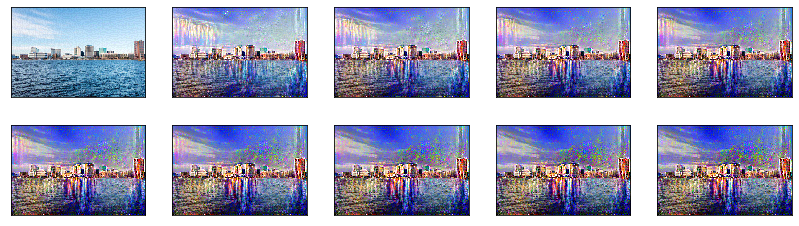

In [0]:
%%time 
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

best, best_loss = run_style_transfer(content_path, style_path, num_iterations = 5000)

In [0]:
def displayResults(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)
  # Ploting the Content Image
  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')
  # Ploting the Style Image
  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')
  if show_large_final: 
    plt.figure(figsize=(10, 10))
    # Ploting the ouptut Image
    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

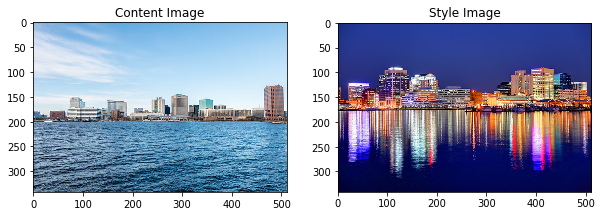

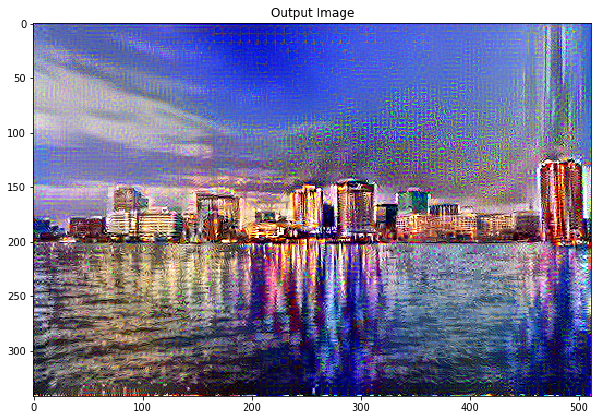

In [0]:
displayResults(best, content_path, style_path)

# References:
https://www.tensorflow.org/tutorials/generative/style_transfer  
https://classroom.udacity.com/courses/ud188  
https://www.packtpub.com/in/big-data-and-business-intelligence/hands-transfer-learning-python  
https://github.com/udacity/deep-learning-v2-pytorch/blob/master/style-transfer/Style_Transfer_Solution.ipynb  
